In [10]:
%load_ext autoreload
%autoreload 2 

import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd 
from ggplot import *
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)

In [3]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.elu(self.l1(x))
        x = F.sigmoid(self.l2(x))
        return self.l3(x)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.elu(self.l1(x))
        x = F.sigmoid(self.l2(x))
        return F.sigmoid(self.l3(x))

In [5]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)


In [6]:
d_sampler = get_distribution_sampler(4, 1.25)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=1, hidden_size=50, output_size=1)
D = Discriminator(input_size=d_input_func(100), hidden_size=50, output_size=1)

In [7]:
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)
num_epochs = 30000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [8]:
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [9]:
# for epoch in range(num_epochs):
plot_mean = []
plot_sd = []

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        d_real_data = Variable(d_sampler(d_input_size))
        d_real_decision = D(preprocess(d_real_data))
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  
        d_real_error.backward() 

        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        d_fake_data = G(d_gen_input).detach() 

        d_fake_decision = D(preprocess(d_fake_data.t()))
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  
        d_fake_error.backward()
        d_optimizer.step()     

    for g_index in range(g_steps):
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine

        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters

    if epoch % print_interval == 0:
        plot_mean.append(np.mean(extract(d_fake_data)))
        plot_sd.append(np.std(extract(d_fake_data)))
        print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))

/home/mfc/.virtualenvs/py3.5/lib/python3.5/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: D: 0.5254591703414917/0.9051386117935181 G: 0.5195666551589966 (Real: [4.015106571912765, 1.397947516134922], Fake: [0.16927915275096894, 0.02232927201532947]) 
200: D: 0.21456828713417053/0.4496590197086334 G: 0.9921163320541382 (Real: [4.023850160837173, 1.1690203956039096], Fake: [0.22845430672168732, 0.09791922664993542]) 
400: D: 0.20097532868385315/0.32735276222229004 G: 1.3988367319107056 (Real: [3.854648718833923, 1.2079312847339465], Fake: [0.37193973664194346, 0.3241035267630061]) 
600: D: 0.27356183528900146/0.33301326632499695 G: 1.2162061929702759 (Real: [4.168875058889389, 1.1856773510486942], Fake: [1.2565406098216771, 0.7369376107634232]) 
800: D: 0.6899008750915527/0.5223632454872131 G: 0.6924309730529785 (Real: [3.9011418703198433, 1.3982102362217343], Fake: [2.838778377175331, 1.1648851656142485]) 
1000: D: 0.6533823013305664/1.1217916011810303 G: 0.5315878391265869 (Real: [4.087065593004227, 1.2595414949814943], Fake: [4.298394447565078, 1.1930637268017397]) 
120

In [24]:
df = pd.DataFrame({'mean': plot_mean, 'sd': plot_sd, 'index': range(len(plot_mean))})
df.index = range(len(plot_mean))

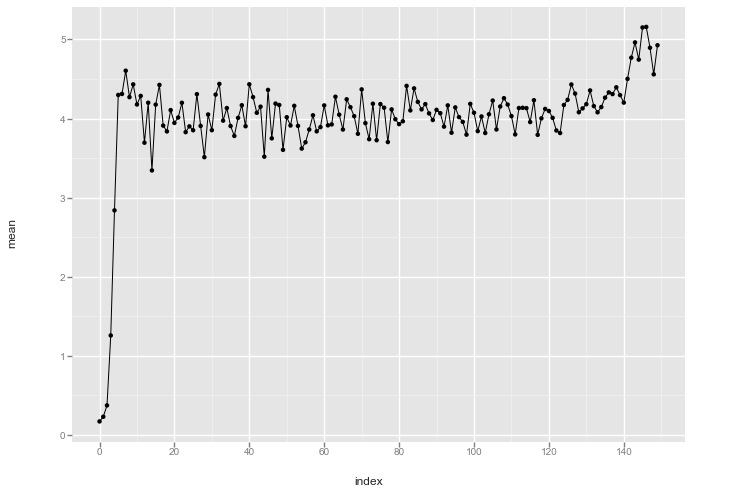

<ggplot: (8779112261559)>

In [26]:
p = ggplot(aes(x='index', y='mean'), data=df) + geom_point() + geom_line()
p

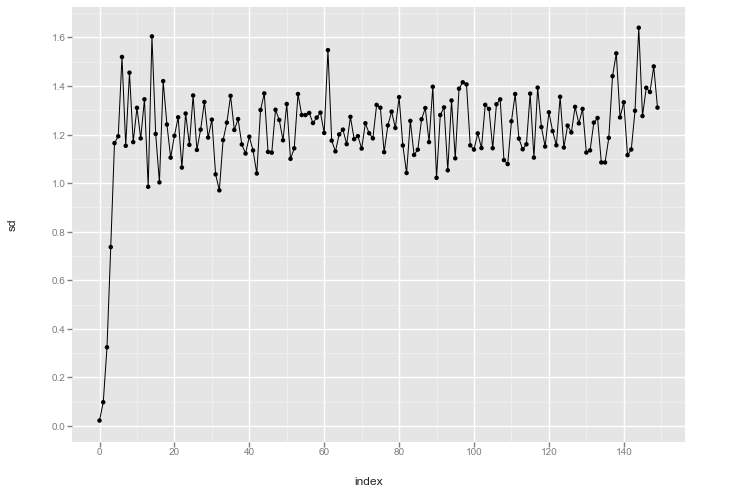

<ggplot: (8779112239101)>

In [27]:
p = ggplot(aes(x='index', y='sd'), data=df) + geom_point() + geom_line()
p